<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Выбор локации для скважины

Допустим, что мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Возможную прибыль и риски проанализируем техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Признаки:
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек;

Целевой признак:
- `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Ход проекта**

Данные геологоразведки трёх регионов получены из файлов `geo_data_0.csv`, `geo_data_1.csv`, `geo_data_2.csv`.

Решение пройдёт в пять этапов:
1. Обзор и подготовка данных для обучения.
2. Построение модели машинного обучения.
3. Подготовка данных к расчёту прибыли.
4. Расчёт прибыли и рисков.
5. Общий вывод.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
geo_df_0 = pd.read_csv('geo_data_0.csv')
geo_df_1 = pd.read_csv('geo_data_1.csv')
geo_df_2 = pd.read_csv('geo_data_2.csv')

Количество дубликатов: 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


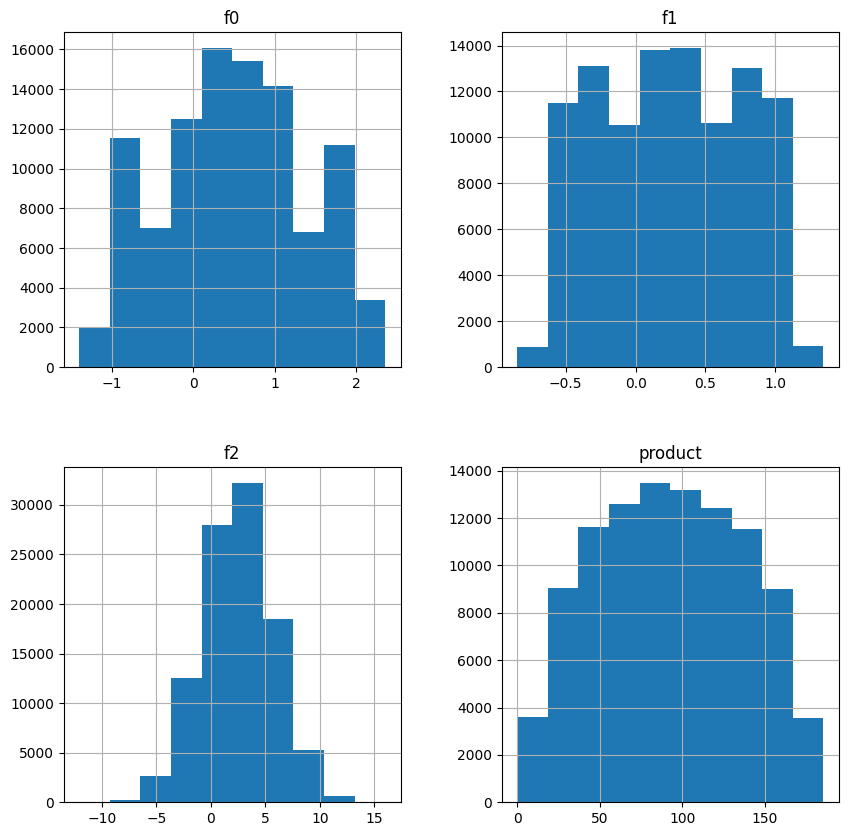

In [3]:
# функция вызывающая все методы для обзора данных
def data_review(data):
    print('Количество дубликатов:', data.duplicated().sum())
    display(data.head(10))
    display(data.info())
    display(data.describe())
    data.hist(figsize=(10, 10));
    
# вызовем функцию, чтобы вывести информацию о датафрейме под номером 0
data_review(geo_df_0)

Количество дубликатов: 0


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


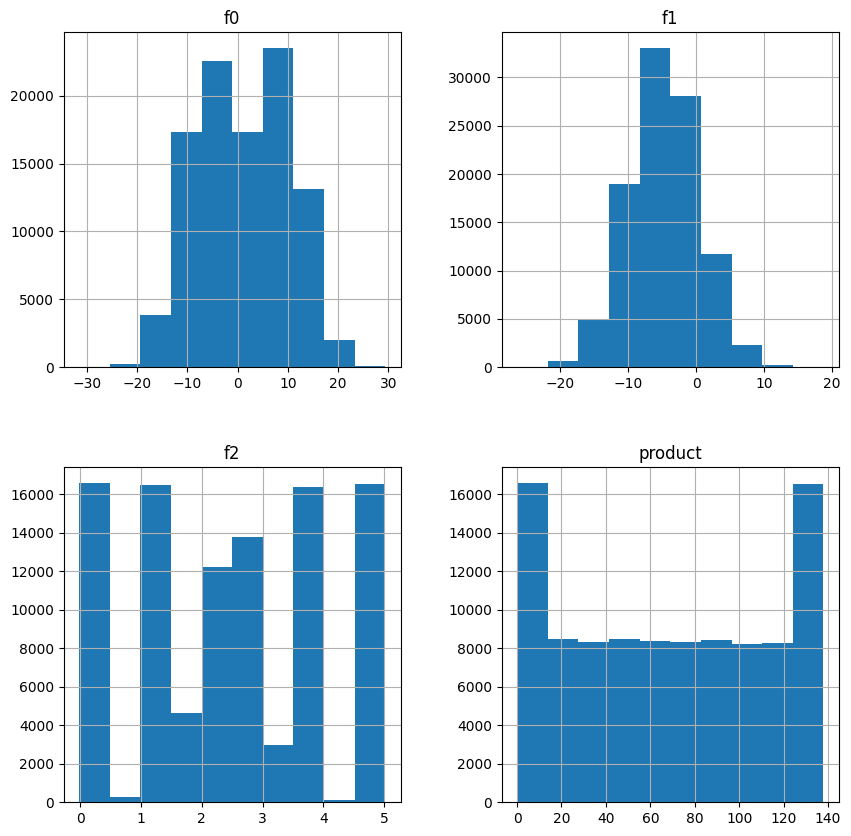

In [4]:
# вызовем функцию, чтобы вывести информацию о датафрейме под номером 1
data_review(geo_df_1)

Количество дубликатов: 0


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


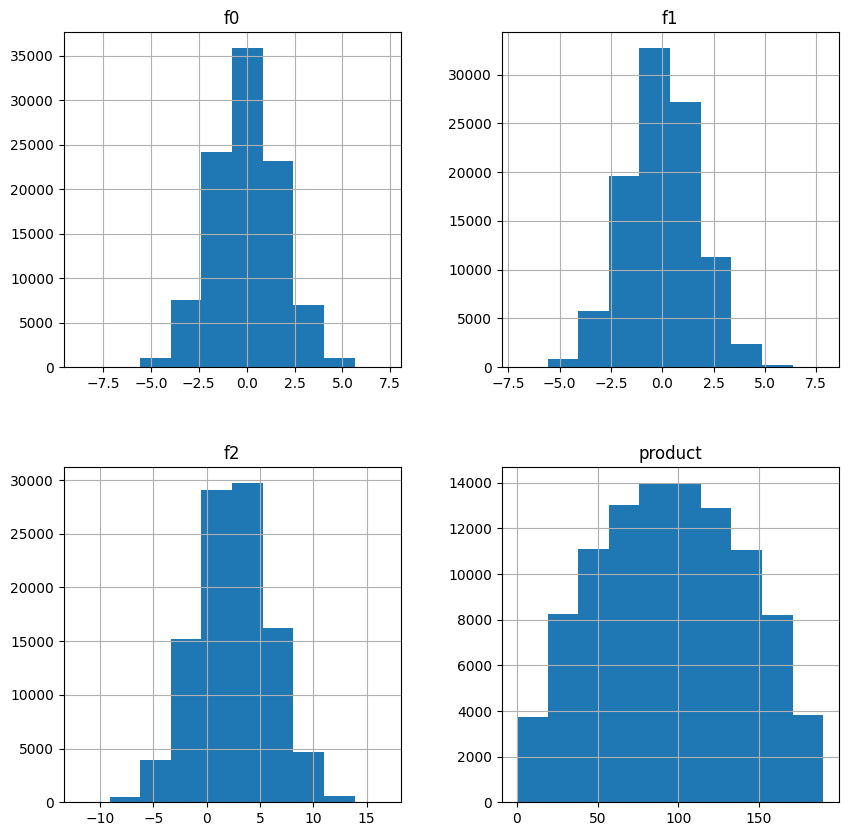

In [5]:
# вызовем функцию, чтобы вывести информацию о датафрейме под номером 2
data_review(geo_df_2)

Пропуски и дубликаты отсутствуют, в столбцах используются корректные типы данных. В регионе под номером 1 (geo_df_1) можно увидеть не нормальное распрделение признаков `f2` и `product`. В остальных двух регионах объекты в этих столбцах распределены нормально. Это стоит учесть при дальнейшем анализе.

Проверим, повторяются ли идентификаторы скважин. Возможно, мы сможем заменить индексы в таблицах на эти идентификаторы.

In [6]:
geo_df_0[geo_df_0.duplicated(subset='id')]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


Уже в нулевом датафрейме мы обнаружили повторы в столбце `id`. Заменить индексы в датафреймах на значения из данного столбца не выйдет, так как получатся несколько строк с неуникальными индексами. Для дальнейшего анализа данные этого столбца не слишком важны, и, если их оставить, то они помешают обучению нашей модели. Просто исключим этот столбец из выборки.

In [7]:
geo_df_0 = geo_df_0.drop('id', axis=1)
geo_df_1 = geo_df_1.drop('id', axis=1)
geo_df_2 = geo_df_2.drop('id', axis=1)

**Вывод**


Обзор данных выявил, что пропуски и дубликаты отсутствуют, в столбцах используются корректные типы данных. Из всех таблиц был удалён столбец с уникальным идентификатором скважины, поскольку он помешал бы обучению нашей модели. 
Преобразование категориальных признаков не требуется, поскольку таблицы содержат только количественные признаки. Масштабирование количетсвенных признаков не требуется, поскольку по условию задачи мы для обучения моделей используем линейную регрессию.

## Обучение и проверка модели

Создадим функцию, которая будет принимать на вход данные, разбивать их на выборки, строить модель, возвращать средний запас предсказанного сырья и *RMSE* модели.

In [8]:
state = np.random.RandomState(12345)

def split_fit_predict(data):
    features =  data.drop('product', axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size = 0.25, random_state=state)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    return predictions, target_valid

Выведем на экран средний запас предсказанного сырья и *RMSE* для каждого из регионов.

In [9]:
geo_df_arr = [geo_df_0, geo_df_1, geo_df_2]
predictions_list = []
target_valid_list = []

for i in range(len(geo_df_arr)):
    predictions, target_valid = split_fit_predict(geo_df_arr[i])
    predictions_list.append(predictions)
    target_valid_list.append(target_valid)
    rmse = round((mean_squared_error(predictions, target_valid))**0.5, 2)
    avg_product = round(predictions.mean(), 2)
    print(f'RMSE модели в {i} регионе: {rmse}')
    print(f'Cредний запас предсказанного сырья в {i} регионе: {avg_product}')

RMSE модели в 0 регионе: 37.58
Cредний запас предсказанного сырья в 0 регионе: 92.59
RMSE модели в 1 регионе: 0.89
Cредний запас предсказанного сырья в 1 регионе: 68.77
RMSE модели в 2 регионе: 39.96
Cредний запас предсказанного сырья в 2 регионе: 95.09


В регионах 0 и 2 модели в среднем очень сильно ошибаются в своём прогнозе. Значения *RMSE* слишком высокие относительно среднего запаса сырья в скважине. Модель в среднем ошибается примерно на **38** тыс. баррелей в своём предсказании при средней заполненности скважины в около **94** тыс. баррелей.

В регионе 1 линейная регрессия показала гораздо более лучшие результаты. Значение *RMSE* равняется **0.89**, а средний запас сырья составляет **68.77**. То есть заполненности скважин в среднем около **70** тыс. баррелей (по предсказнаю модели), а модель ошибается в своём прогнозе примерно на **1** тыс. баррелей. 

Ранее мы замечали, что в регионе 1 значения объектов в стоблцах `f2` и `product` распределены иначе, чем в регионах 0 и 2. Возможно, это и является причиной таких результатов предсказания целевого признака. Проверим данные в регионе 1 на наличие зависимостей между признаками.

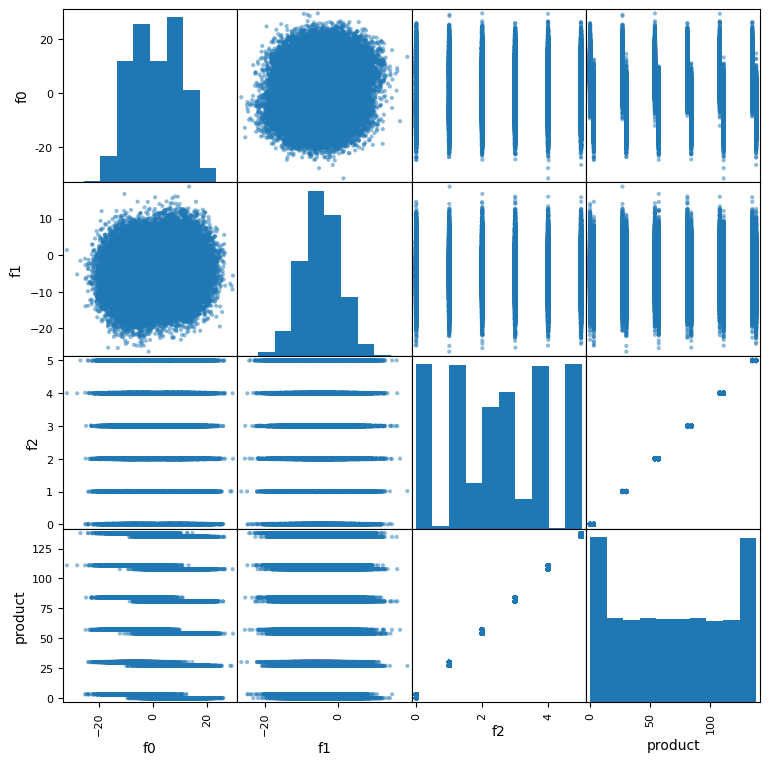

In [10]:
pd.plotting.scatter_matrix(geo_df_1, figsize=(9, 9));

In [11]:
geo_df_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Как и предполагалось, в 1 регионе существует очень сильная линейная зависимость между признаками `f2` и `product`, что подтверждают графики и коэффициент корреляции в **0.99**. Посмотрим на ситуацию в других регионах.

In [12]:
geo_df_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [13]:
geo_df_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Как видим, в других регионах зависимость этих признаков гораздо ниже, что объясняет более худшее качество модели на данных из регионов 0 и 2.

**Вывод**


В данном разделе мы разбили данные на выборки, обучили модели линейной регрессии и получили следующие результаты. В регионах 0 и 2 значения *RMSE* слишком высокие относительно среднего запаса сырья в скважине. Для региона 1 модель очень хорошо предсказывает значение целевого признака. *RMSE* такой модели достаточно низкий относительно среднего предсказанного сырья. Это можно объяснить сильной линейной зависимостью в регионе 1 между признакаом `f2` и целевым признаком. Модель обнаружила эту связь и выдавала достаточно точные предсказания.

## Подготовка к расчёту прибыли

Добавим несколько констант, которые будем использовать для рассчета прибыли.

In [14]:
# бюджет на разработку скважин в регионе
BUDGET_PER_REGION = 10_000_000 
# количество точек, которое нужно исследовать при разведке региона
POINTS_FOR_RESEARCH = 500 
# количество лучших точек для разработки, которое мы выбираем с помощью машинного обучения 
POINTS_FOR_DEVELOP = 200 
# доход с каждой единицы продукта (в тыс. рублей)
UNIT_PRICE = 450 

Рассчитаем необходимый объём сырья в новых скважинах, при котором мы не уйдем в убыток. 

In [15]:
min_product_count = (BUDGET_PER_REGION / (POINTS_FOR_DEVELOP * UNIT_PRICE))
min_product_count

111.11111111111111

В нашем случае неубыточной будет считать скважина, в которой будет находиться не менее **111.11** тыс. баррелей нефти.

**Вывод**


В данном разделе мы рассчитали минимальное количество сырья в скважине, чтобы она окупила затраты на свою разработку. Пока что во всех трёх рассматриваемых нами регионах среднее количество сырья в скважине гораздо меньше. Возможно, если рассматривать лишь несколько самых лучших скважин в регионах, то это улучшит средние показатели и мы сможем вынести прибыль.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [16]:
def revenue(target, predictions, count):
    # выберем скважины с максимальными предсказаниями
    predictions_sorted = predictions.sort_values(ascending=False)
    # выберем скважины с максимальными предсказаниями и извлечем фактические значения сырья в данных скважинах 
    selected = target[predictions_sorted.index][:count]
    # просуммируем целевое значение объёма сырья
    total_product = selected.sum()
    # рассчитаем прибыль/убыток для полученного объёма сырья
    profit = (total_product * UNIT_PRICE) - BUDGET_PER_REGION 
    return profit

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

Регион под номером 0. Средняя прибыль: 423.9 млн. рублей
Регион под номером 0. 95%-й доверительный интервал: от -76.19 до 957.85
Регион под номером 0. Риск потерпеть убытки: 4.8%


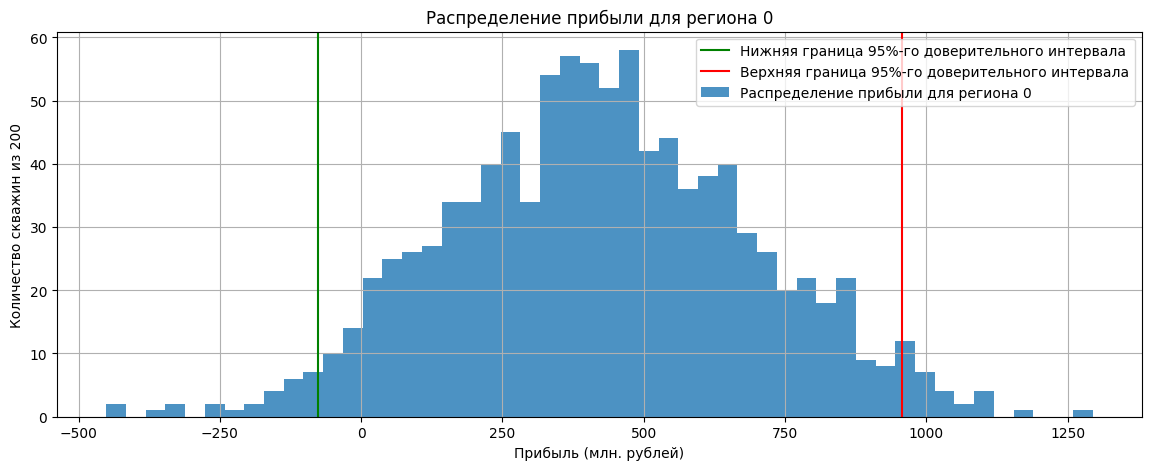

Регион под номером 1. Средняя прибыль: 513.26 млн. рублей
Регион под номером 1. 95%-й доверительный интервал: от 108.07 до 928.57
Регион под номером 1. Риск потерпеть убытки: 0.6%


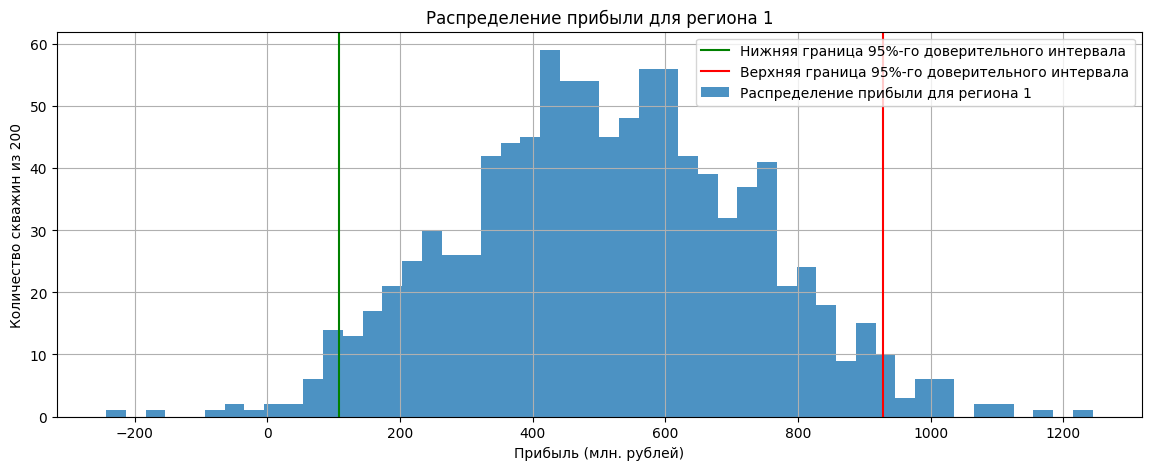

Регион под номером 2. Средняя прибыль: 381.12 млн. рублей
Регион под номером 2. 95%-й доверительный интервал: от -142.8 до 893.38
Регион под номером 2. Риск потерпеть убытки: 7.4%


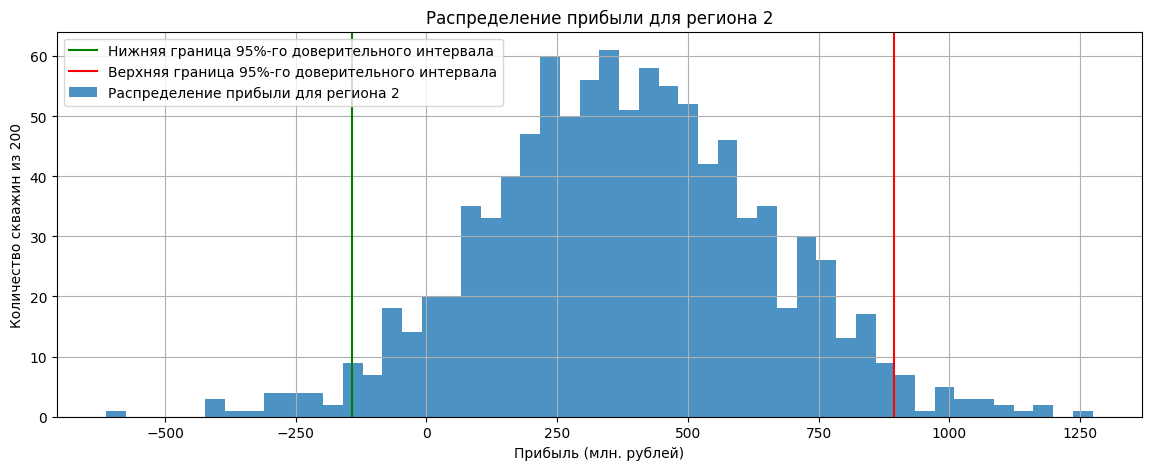

In [17]:
for i in range(len(geo_df_arr)):
    predictions = predictions_list[i]
    target = target_valid_list[i]
    # делаем предикты объектом Series, чтобы применить к нему метод сортировки
    predictions = pd.Series(predictions) 
    # обнуляем индексы, чтобы они соотвествовали индексам предиктов
    target = target.reset_index(drop=True)
    values = []
    # выполняем технику Bootstrap с 1000 выборок, распределение сохраняем в values
    for j in range(1000):
        target_subsample = target.sample(n=POINTS_FOR_RESEARCH, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        values.append(revenue(target_subsample, predictions_subsample, POINTS_FOR_DEVELOP))
    values = pd.Series(values)
    lower = round(values.quantile(0.025)/1000, 2) 
    upper = round(values.quantile(0.975)/1000, 2)
    mean = round(values.mean()/1000, 2) # делим на 1000, чтобы получить значения в млн. рублей, а не тысячах   
    risk = round((values < 0).mean()*100, 2) # рассчитываем риск убытков в случае выбора данного региона
    print(f'Регион под номером {i}. Средняя прибыль: {mean} млн. рублей')
    print(f'Регион под номером {i}. 95%-й доверительный интервал: от {lower} до {upper}')
    print(f'Регион под номером {i}. Риск потерпеть убытки: {risk}%')
    
    # построим гистограммы распределения прибыли для трёх регионов
    (values/1000).hist(figsize=(14, 5), bins=50, alpha=0.8)
    plt.grid(True)
    plt.axvline(lower, color='green')
    plt.axvline(upper, color='red')
    plt.legend(['Нижняя граница 95%-го доверительного интервала', 
                'Верхняя граница 95%-го доверительного интервала', 
                f'Распределение прибыли для региона {i}'])
    plt.xlabel('Прибыль (млн. рублей)')
    plt.ylabel('Количество скважин из 200')
    plt.title(f'Распределение прибыли для региона {i}')
    plt.show()

**Вывод**


Мы рассчитали возможную прибыль и оценили риски потерпеть убытки для каждого региона. На мой взгляд, самым оптимальным вариантом для разработки скважин является регион из датасета `geo_data_1.csv`. Риск не окупить затраченные на разработку средства в данном регионе составляет всего **0.6%**. Это удовлетворяет условию задачи о том, что  вероятность убытков должна быть меньше **2.5%**. В остальных регионах это условие не выполняется, там риски потерпеть убытки слишком велики. Кроме того, в регионе под номером 1 средняя прибыль составляет **513.26** млн. рублей, что даже выше, чем в двух других регионах.

## Общий вывод

В ходе исследования мы провели работу для прогнозирования наилучшей локации для разработки скважин.

Исследуя данные, мы:
1. Выполнили обзор и подготовили датафреймы для применения методов машинного обучения.
2. Обучили модели линейной регрессии для каждого региона и определили, что лучшими показателями обладает модель построенная для региона под номером 1.
3. Рассчитали минимальное количество сырья в скважине, чтобы она окупила затраты на свою разработку. Оно составляет **111.11** тыс. баррелей нефти.
4. Рассчитали возможную прибыль и оценили риски потерпеть убытки для каждого региона. Разработку предложено вести в регионе под номером. В данном регионе наибольшая средняя прибыль (**513.26** млн. рублей) и наименьший риск потерять вложенные средства (**0.6%**).